In [1]:
# import sys
# sys.path.insert(0, '../../src')

import quik_ai as qa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras

from importlib.metadata import version 
print('Quik-AI Version: %s' % version('quik_ai'))

Quik-AI Version: 1.3.1


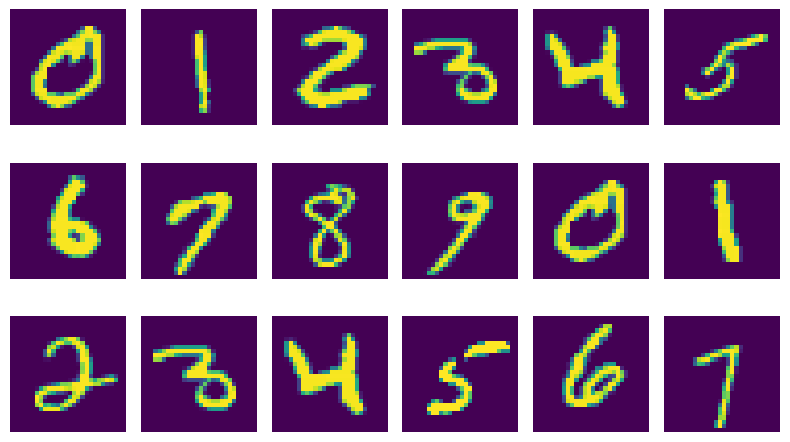

In [2]:
# fetch the data
(x_train, y_train), _ = keras.datasets.mnist.load_data()

# make a dataframe
data = pd.DataFrame({
    'X' : list(x_train)[:50],
    'y' : y_train[:50]
})

# get a dictionary to map to all samples of digits
grouped = data.groupby('y')['X'].apply(list)
grouped_dict = grouped.to_dict()

# create our datasets
training_data = pd.DataFrame({
    'y' : np.arange(4000) % 10,
})
training_data['X'] = training_data['y'].apply(lambda x: grouped_dict[x][np.random.randint(len(grouped_dict[x]))] / 255.0)

testing_data = pd.DataFrame({
    'y' : np.arange(600) % 10,
})
testing_data['X'] = testing_data['y'].apply(lambda x: grouped_dict[x][np.random.randint(len(grouped_dict[x]))] / 255.0)

# plot a sample of digits
fig, axes = plt.subplots(3, 6, figsize=(8, 5))

for i, ax in enumerate(axes.flatten()):
    # Plot the image
    img = training_data['X'].iloc[i]
    ax.imshow(img, vmin=0, vmax=1)

    # Remove the axes
    ax.axis('off')

# Adjust the space between plots if needed
plt.tight_layout()
plt.show()

In [3]:
# create the driver, this will generate the tensorflow dataset and feed data
driver = qa.Driver(training_data, testing_data, testing_data, batch_size=64)

# what does our response look like?
head = qa.heads.Regression(event_shape=(28, 28), loss_name='mean_absolute_error')

# all the predictors for the model
predictors = [
    qa.predictors.Image('X', height=14, mask_n=1, standardize=False),
]

# what is our model architecture? This will store
# our model, driver, and any other information we use in training
# testing, saving, and loading needed for this problem
model = qa.models.ResNet('X', head, predictors, driver, time_window=10)

# train the model, we can provide a hyperparameter tuner and other
# training parameters, by default we will use a custom BOHB tuner
model.train(tuner_params={'max_epochs' : 10})

Trial 30 Complete [00h 00m 13s]
val_mean_absolute_error: 0.104372538626194

Best val_mean_absolute_error So Far: 0.0786079689860344
Total elapsed time: 00h 07m 05s
INFO:tensorflow:Oracle triggered exit
Round 1 best score: 0.0781


In [4]:
# evaluate the model on test data
model.evaluate()

10/10 [==============================] - 0s 6ms/step - loss: 0.0781 - mean_absolute_error: 0.0781


{'loss': 0.07813061028718948, 'mean_absolute_error': 0.07813061028718948}

In [5]:
# save the model to disk and reload the model
# then test on the test data once again
model.save()
model = qa.HyperModel.load()

# evaluate again, this should be the same score as before
model.evaluate()

INFO:tensorflow:Assets written to: ./model\tf_model\assets


INFO:tensorflow:Assets written to: ./model\tf_model\assets


10/10 [==============================] - 0s 8ms/step - loss: 0.0781 - mean_absolute_error: 0.0781


{'loss': 0.07813061028718948, 'mean_absolute_error': 0.07813061028718948}

In [6]:
model.instance.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X (InputLayer)                 [(None, 10, 28, 28)  0           []                               
                                ]                                                                 
                                                                                                  
 history_dropout_1 (HistoryDrop  (None, 10, 28, 28)  0           ['X[0][0]']                      
 out)                                                                                             
                                                                                                  
 tf.identity_3 (TFOpLambda)     (None, 10, 28, 28)   0           ['history_dropout_1[0][0]']      
                                                                                            

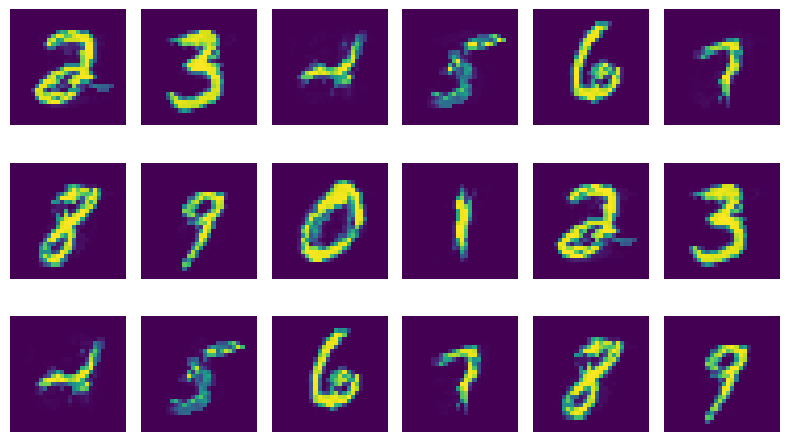

In [7]:
predictions = model.predict(testing_data, verbose=0)

# plot a sample of digits
fig, axes = plt.subplots(3, 6, figsize=(8, 5))

for i, ax in enumerate(axes.flatten()):
    # Plot the image
    img = predictions[-len(axes.flatten()) + i]
    ax.imshow(img, vmin=0, vmax=1)

    # Remove the axes
    ax.axis('off')

# Adjust the space between plots if needed
plt.tight_layout()
plt.show()